In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.animation as animation

import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
#from multiprocessing import Pool, Array, Process
#from multiprocessing import cpu_count

import os
import pyart
from netCDF4 import num2date, date2num
from IPython.display import HTML

def animate_frame(i,ax1,ax2,file_list,mod_no):
    ax1.clear()
    ax2.clear()
    fl = file_list[i]
    plot_object = load_plot_scan(ax1,ax2,fl,mod_no,cbf=False) 
    return plot_object

def clusterLoop(mod_no):
    fig = plt.figure(figsize = [10,8])
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)

    #Select model
    #mod_no = 7

    #Extract means from model
    k = models[mod_no].n_components

    #Generate discrete cmap
    dcmap = discrete_cmap(k,'pyart_NWSRef')

    first_scan = load_plot_scan(ax1,ax2,fls_185[0],mod_no,cbf=True)

    ani = animation.FuncAnimation(fig, animate_frame, frames=np.arange(len(fls_185)), 
        fargs=(ax1,ax2,fls_185,mod_no), interval=250)
    #plt.close()
    #ani.save(os.path.basename(model_fn)[:-4]+'_k'+str(k)+'.mp4')
    return ani
#plt.clf()

### Define all functions

def load_plot_scan(ax1,ax2,vol_fn,mod_no,cbf):
    #vol_fn = fls[x]
    myradar = pyart.aux_io.read_odim_h5('/'.join([dirr,vol_fn]), file_field_names=True)
    model_name = 'GMM_n' + str(models[mod_no].n_components)
    outloc = '/'.join(['.','plots',name_of_plot_run,model_name])
    myradar.add_field(model_name,predict_labels(myradar,models[mod_no],filt=gfilt))
    plot_out = plot_k_and_ref(ax1,ax2,myradar,tilt,outloc,model_name,models[mod_no].n_components,cbf)

    #print('Finished '+ vol_fn)
    return plot_out


def give_gatefilter(myradar):

    try:
        myradar.check_field_exists('SNR')
    except:
        myradar.add_field('SNR',
                          pyart.retrieve.calculate_snr_from_reflectivity(myradar,
                                                                         refl_field='DBZH',
                                                                         snr_field=None,
                                                                         toa=25000.0))

    # Set gatefilters
    gatefilter = pyart.correct.GateFilter(myradar)
    if VRADH_inside is not None:
        gatefilter.exclude_inside('VRADH',VRADH_inside[0],VRADH_inside[1])
    if VRADH_outside is not None:
        gatefilter.exclude_outside('VRADH',VRADH_outside[0],VRADH_outside[1])
    if snr_cutoff is not None:
        gatefilter.exclude_below('SNR',snr_cutoff)
    if depseck_size is not None:
        gatefilter = pyart.correct.despeckle.despeckle_field(myradar,
                                                     'VRADH',
                                                     gatefilter=gatefilter,
                                                     size = depseck_size)
    return gatefilter

def predict_labels(myradar,model,filt=True):

    from pyart.config import get_metadata

    #models[4]
    #m =4

    #fields = ['DBZH','ZDR','RHOHV','WRADH','KDP','ALT']

    gatefilter = None
    pred_data = np.zeros((myradar.fields['DBZH']['data'][:].flatten().size,6))
    orig_shape = np.shape(myradar.fields['DBZH']['data'][:])

    for f in range(len(fields)):
        if fields[f] == 'ALT':
            returns = myradar.gate_z['data'][:].flatten()
            pred_data[:,f] = returns
        else:
            returns = myradar.fields[fields[f]]['data'][:].flatten()
            pred_data[:,f] = returns

        ### Do classification here, assume 1D output

    labels = np.reshape(model.predict(pred_data),orig_shape)
    ['GMM_n' + str(model.n_components)]
    #predict_labels(myradar,model[])

    GMM_field = get_metadata(myradar)
    GMM_field['data'] = labels
    GMM_field['units'] = 'NA'
    GMM_field['standard_name'] = 'GMM_n' + str(model.n_components)
    GMM_field['long_name'] = 'Labels as predict by Gaussian Mixture Model where k = ' + str(model.n_components)
    return GMM_field

def discrete_cmap(N, base_cmap=None):
    import matplotlib.pyplot as plt
    """Create an N-bin discrete colormap from the specified input map"""

    #Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a 
    
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_k_and_ref(ax1,ax2,myradar,tilt,outloc,model_name,k,cbf):
    #import matplotlib.pyplot as plt
    
#    if myradar.scan_type is 'rhi':
#        if np.round(myradar.azimuth['data'][0]) == 185.0:
#            if myradar.elevation['data'][-1] < myradar.elevation['data'][0]:
#                myradar.elevation['data'] = (myradar.elevation['data'] + 
#                                             np.full_like(myradar.elevation['data'],downadjust))


        
        
    if myradar.scan_type is 'rhi':
        

        #fig = plt.figure(figsize = [10,8])
        dts = num2date(myradar.time['data'][0] + tz* 60.*60., myradar.time['units'])
        dcmap = discrete_cmap(k,'pyart_NWSRef')
        if gfilt:
            gatefilter = give_gatefilter(myradar)
        else:
            gatefilter = None
        
        plt.sca(ax1) # = plt.subplot(2,1,1)
        display1 = pyart.graph.RadarMapDisplay(myradar)
        
        out1 = display1.plot('DBZH', 0,
                     vmin=minref, vmax=maxref,
                     title_flag=False,
                     cmap = pyart.graph.cm.RRate11,
                     gatefilter = gatefilter,
                     colorbar_flag = cbf,
                     axislabels = axislabs,
                    )
            
        display1.set_limits(RHIxlims,RHIylims)
        
            
        plt.sca(ax2)
        display2 = pyart.graph.RadarMapDisplay(myradar)
        
        out2 = display2.plot(model_name,0,
                             title_flag=False,
                             cmap = dcmap,
                             gatefilter = gatefilter,
                             colorbar_flag = cbf,
                             axislabels = axislabs,
                             ticks=[x+0.5 for x in range(0,k+1)],#range(1,N_cmap),
                             ticklabs=[str(x+1) for x in range(0,k)]
                            )
                            
        
        display2.set_limits(RHIxlims,RHIylims)

        #fn = firename +'_' + dts.strftime('%H%M%S')

        #plt.savefig(outloc + '/' +fn +'_tilt_' +'.png',dpi=150)

        #plt.close()

    return [out1, out2]


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Load ffmpeg driver

In [2]:
FFMpegWriter = animation.writers['ffmpeg']

In [3]:
metadata = dict(title='Mt Bolton GMM clusters where k = 4', artist='Carpentry@UIO',
                comment='Using UQXPOL radar data')
writer = FFMpegWriter(fps=10, metadata=metadata)

### Set basic paths and radar parameters

In [4]:
### Set key parameters
dirr = './raw_data/Mt Bolton/radar_hdf/'
test = True
model_fn = './models/Mt_Bolton_altitude_4_12.gmm'

firename = 'MtBolton'
gfilt = True

#Exclude values above this SNR value
snr_cutoff = 2
#Exclude values inside these values
VRADH_inside = None #[-0.5,0.5]
#Exclude values outside these values
VRADH_outside = None #[-10,10]
#Apply despeckle filter on VRADH with this minimum no of pixels
depseck_size = None #10

axislabs=('Distance from UQ-XPOL (km)', 'Height (km)')

RHIxlims, RHIylims = [5,28],[0, 7]
downadjust = 0.3

minref = 0
maxref = 35

tz=11

fields = ['DBZH','ZDR','RHOHV','WRADH','KDP','ALT']

name_of_plot_run = 'Mt Bolton All Clusters'
tilt = 0

### Loop through, keep valid files
We only want RHIs at the azimuth of 185 degrees for these plots. Pickle the result to be used again.

In [11]:
fls = os.listdir(dirr)
fls.sort()
fls_185 = []
for fl in fls:
    myradar = pyart.aux_io.read_odim_h5(dirr+ fl, file_field_names=True)
    if np.round(myradar.azimuth['data'][0]) != 185.0:
        continue
    else:
        fls_185.append(fl)
with open("etc/fls_185.ind", "wb") as fp:
    pickle.dump(fls_185, fp)

In [5]:
fls_185 = pickle.load(open('etc/fls_185.ind', 'rb'))

### Load GMMs

In [6]:
model_fn = 'models/Mt_Bolton_height_all.gmm'

In [7]:
models = pickle.load(open(model_fn, 'rb'))

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

KeyboardInterrupt: 

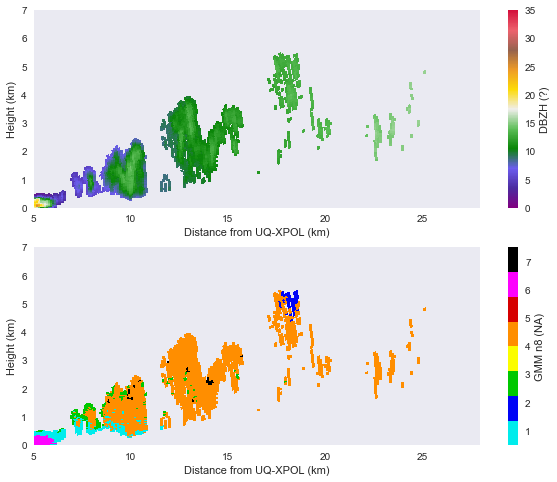

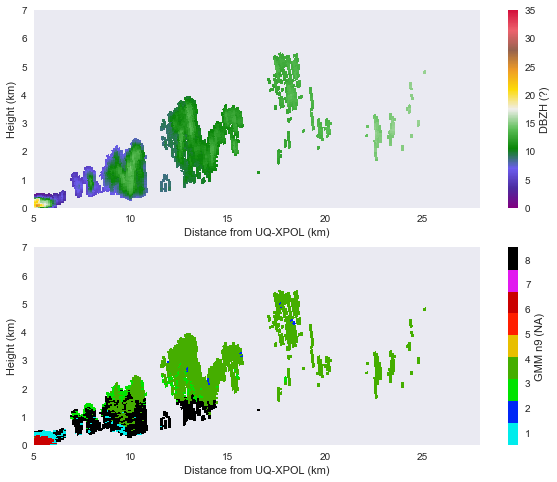

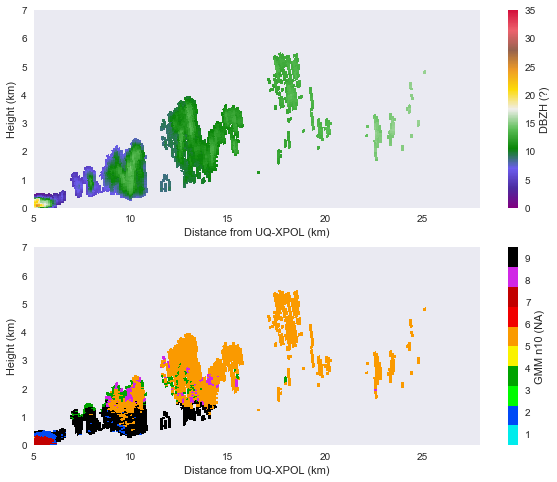

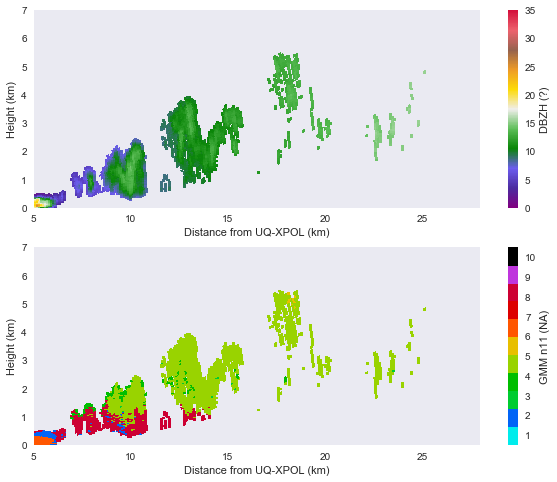

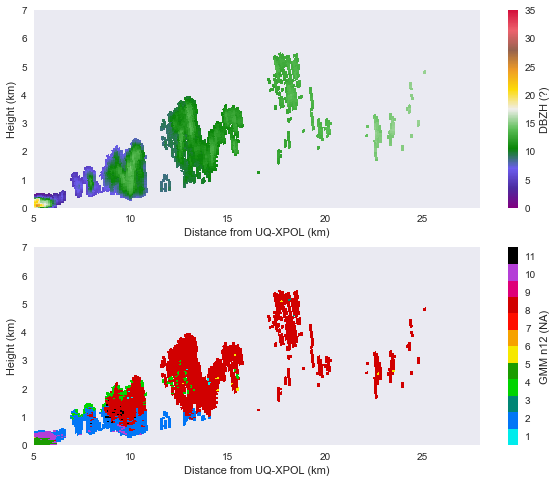

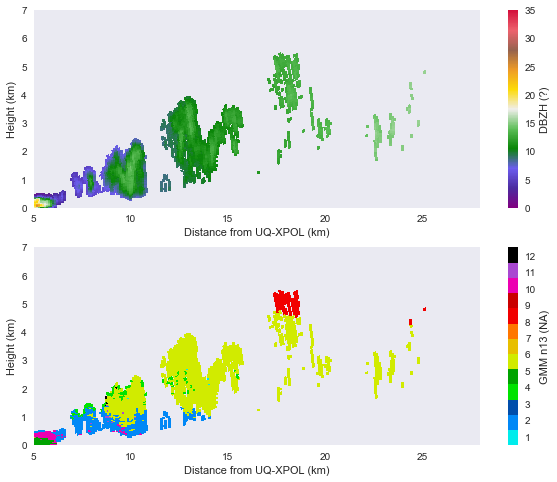

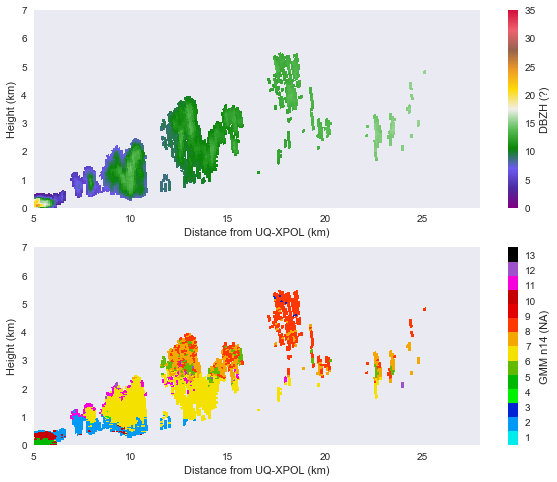

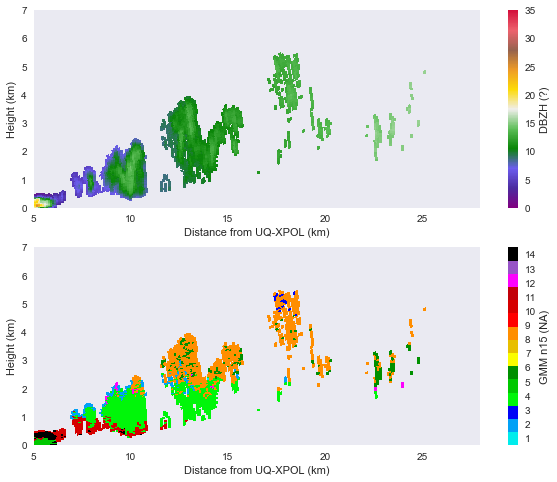

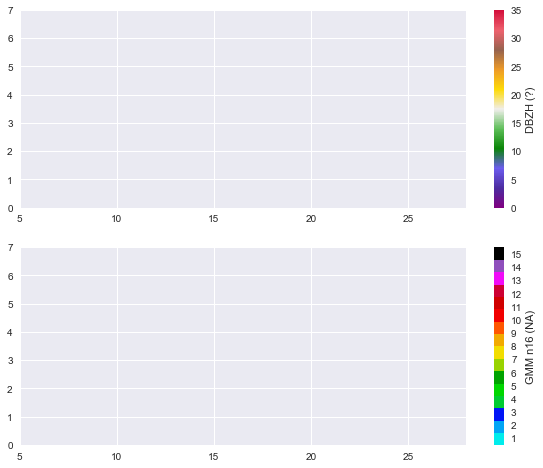

In [11]:
for model_number in range(4,len(models)):
    ani = clusterLoop(model_number)
    k_ = str(models[model_number].n_components)
    ani.save(os.path.basename(model_fn)[:-4]+'_k'+str(k_)+'.mp4')
